In [1]:
%load_ext autoreload
%autoreload 2

# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) with the associated [github](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py).

## Imports 

In [2]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
import itertools
from functools import partial

from sklearn.metrics import r2_score
import os

USE_ONLY_ONE_GPU = False
if USE_ONLY_ONE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 0 or 1

import sys
import numpy as np
import haiku as hk
import jax

from datetime import datetime
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt


jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 01_cvae.ipynb --output=01_cvae_2.ipynb --ExecutePreprocessor.timeout=-1




[cuda(id=0), cuda(id=1)]

In [3]:
from evoscaper.scripts.init_from_hpos import init_from_hpos, make_loss
from evoscaper.utils.math import bin_to_nearest_edge, arrayise
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.optimiser import make_optimiser
from evoscaper.utils.train import train


## Load data

In [4]:
# from evoscaper.scripts.simulate_circuits import summarise_simulated_cicruits, save
# from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict

# analytics = load_json_as_dict('data/simulate_circuits/2025_01_29__18_12_38/analytics.json')
# config = load_json_as_dict('data/simulate_circuits/2025_01_29__18_12_38/config.json')
# interactions = np.load('data/simulate_circuits/2025_01_29__18_12_38/interactions.npy')
# data = summarise_simulated_cicruits(analytics, config, interactions)
# save({'tabulated_mutation_info.json': data}, 'data/simulate_circuits/2025_01_29__18_12_38')

In [5]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# fn = './data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
# data = pd.read_json(fn)
# len(data)

## Hyperparameters

In [6]:
task = 'ds1205'
t_str = make_datetime_str()
top_write_dir = os.path.join('data', '01_cvae', t_str)
save_path = os.path.join(top_write_dir, 'saves_' + t_str + f'_{task}')
os.makedirs(top_write_dir, exist_ok=True)


In [7]:
data_dir = '../data'

hpos_architecture = {
    'seed_arch': 1,
    'hidden_size': 16,
    'enc_ls': 32,
    'dec_ls': 32,
    'num_enc_layers': 2,
    'num_dec_layers': 2,
    'factor_expanding_ls': 1,
    'factor_contracting_ls': 1,
    'model': 'CVAE',
    'use_sigmoid_decoder': False,
    'enc_init': 'HeNormal',
    'dec_init': 'HeNormal',
    'init_model_with_random': True,
    'activation': 'leaky_relu',
}

hpos_training = {
    'seed_train': 1,
    'batch_size': 256,
    'epochs': 1000,
    'patience': 500,
    'threshold_early_val_acc': 0.99,
    'learning_rate': 1e-2,
    'loss_func': 'mse',
    'accuracy_func': 'accuracy_regression',
    'use_dropout': False,
    'dropout_rate': 0.1,
    'use_l2_reg': False,
    'l2_reg_alpha': 5e-2,
    'use_kl_div': True,
    # inspired by https://github.com/elttaes/VAE-MNIST-Haiku-Jax/blob/main/cVAE_mnist.ipynb
    'kl_weight': 2.0e-4,
    'use_grad_clipping': False,
    'use_contrastive_loss': False,
    'temperature': 1.5,
    'contrastive_func': 'info_nce',
    'threshold_similarity': 0.9,
    'power_factor_distance': 3
}
hpos_training['print_every'] = hpos_training['epochs'] // 50

hpos_optimization = {
    'seed_opt': 1,
    'opt_method': 'adam',
    'opt_min_lr': 1e-6,
    'opt_min_delta': 1e-4,
    'learning_rate_sched': 'cosine_decay',
    'use_warmup': True,
    'warmup_epochs': 20,
}

hpos_dataset = {
    'seed_dataset': 1,
    'include_diffs': False,
    # 'objective_col': ('Log sensitivity', 'Log precision'),
    # 'objective_col': 'adaptation',
    'objective_col': 'Log sensitivity',
    'output_species': ('RNA_2',),
    'signal_species': ('RNA_0',),
    # 'filenames_train_config': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/ensemble_config.json',
    # 'filenames_train_table': f'{data_dir}/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv',
    'filenames_train_config': f'{data_dir}/raw/summarise_simulation/2024_12_05_210221/ensemble_config.json',
    'filenames_train_table': f'{data_dir}/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv',
    # 'filenames_train_config': f'./data/simulate_circuits/2025_01_29__18_12_38/config.json',
    # 'filenames_train_table': f'./data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json',
    # 'filenames_train_config': f'./data/simulate_circuits/2025_01_29__14_52_44/config.json',
    # 'filenames_train_table': f'./data/simulate_circuits/2025_01_29__14_52_44/tabulated_mutation_info.json',
    'filenames_verify_config': f'./data/simulate_circuits/2025_02_01__00_22_38/config.json',
    'filenames_verify_table': f'./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json',
    'use_test_data': False,
    # 'total_ds': None,   # TO BE RECORDED
    'total_ds_max': 5e6,
    'train_split': 0.8,
    'x_type': 'energies',
    # XY filtering:
    'filt_x_nans': True,
    'filt_y_nans': True,
    'filt_sensitivity_nans': True,
    'filt_precision_nans': True,
    'filt_n_same_x_max': 1,
    'filt_n_same_x_max_bins': None,
    'filt_response_time_high': True,
    'filt_response_time_perc_max': 0.8,
    # XY preprocessing:
    'prep_x_standardise': False,
    'prep_y_standardise': False,
    'prep_x_min_max': True,
    'prep_y_min_max': True,
    'prep_x_robust_scaling': True,
    'prep_y_robust_scaling': True,
    'prep_x_logscale': False,
    'prep_y_logscale': False,
    'prep_x_categorical': False,
    'prep_y_categorical': False,
    'prep_x_categorical_onehot': False,
    'prep_y_categorical_onehot': False,
    'prep_x_categorical_n_bins': 10,
    'prep_y_categorical_n_bins': 10,
    'prep_x_categorical_method': 'quantile',
    'prep_y_categorical_method': 'quantile',
    'prep_x_negative': True,
    'prep_y_negative': False
}


hpos_eval = {
    'eval_n_to_sample': 1e3
}

info_to_be_recorded = {
    'filename_saved_model': 'TO_BE_RECORDED',
    'total_ds': 'TO_BE_RECORDED',
    'n_batches': 'TO_BE_RECORDED',
    'R2_train': 'TO_BE_RECORDED',
    'R2_test': 'TO_BE_RECORDED',
    'mutual_information_conditionality': 'TO_BE_RECORDED',
    'n_layers_enc': 'TO_BE_RECORDED',
    'n_layers_dec': 'TO_BE_RECORDED',
    'run_successful': 'TO_BE_RECORDED',
    'info_early_stop': 'TO_BE_RECORDED',
    'error_msg': 'TO_BE_RECORDED',
}

hpos_all = {}
for d in [hpos_architecture, hpos_training, hpos_optimization, hpos_dataset, hpos_eval, info_to_be_recorded]:
    hpos_all.update(d)

with open(os.path.join(top_write_dir, 'hpos_all.json'), 'w') as f:
    json.dump(hpos_all, f, indent=4)
hpos = pd.Series(hpos_all)

# Initialise

## Init data

In [8]:
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos)

### Visualise

/tmp/ipykernel_3513201/264580229.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x=df[k], y=df[x_cols].min(axis=1), palette='viridis')


Text(0.5, 0.98, 'Data after transformation')

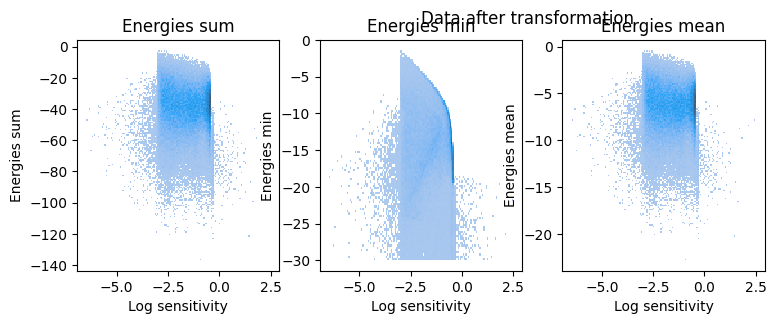

In [9]:
plt.figure(figsize=(4*3, 3))
ax = plt.subplot(1, 4, 1)
for k in config_dataset.objective_col:
    sns.histplot(x=df[k], y=df[x_cols].sum(axis=1))
if config_norm_x.logscale:
    plt.xscale('log')
plt.ylabel('Energies sum')
plt.title('Energies sum')
ax = plt.subplot(1, 4, 2)
for k in config_dataset.objective_col:
    sns.histplot(x=df[k], y=df[x_cols].min(axis=1), palette='viridis')
    # hue=df[x_cols].mean(axis=1))
if config_norm_x.logscale:
    plt.xscale('log')
plt.ylabel('Energies min')
plt.title('Energies min')
ax = plt.subplot(1, 4, 3)
for k in config_dataset.objective_col:
    sns.histplot(x=df[k], y=df[x_cols].mean(axis=1))
if config_norm_x.logscale:
    plt.xscale('log')
plt.ylabel('Energies mean')
plt.title('Energies mean')

plt.suptitle('Data after transformation')

### Reduce circuits that are overrepresented

Text(0.5, 1.0, 'Sensitivity after balancing')

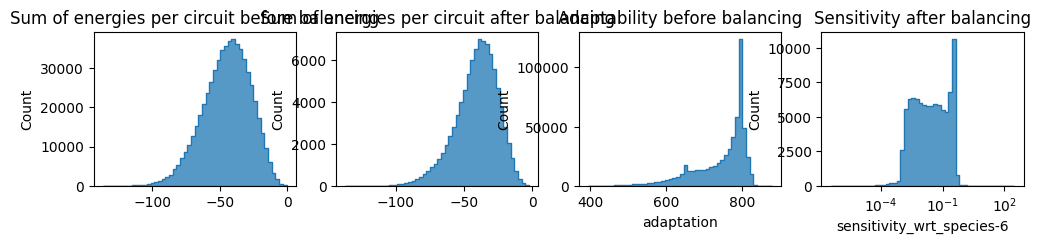

In [10]:
fig = plt.figure(figsize=(3*4, 2))
ax = plt.subplot(1,4,1)
sns.histplot(data[x_cols].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit before balancing')
# ylim = ax.get_ylim()
ax = plt.subplot(1,4,2)
sns.histplot(df[x_cols].sum(axis=1), bins=50, log_scale=[False, False], element='step')
plt.title('Sum of energies per circuit after balancing')
# plt.ylim(ylim)
ax = plt.subplot(1,4,3)
sns.histplot(data, x='adaptation', bins=50, log_scale=[False, False], element='step')
plt.title('Adaptability before balancing')
ax = plt.subplot(1,4,4)
sns.histplot(df, x='sensitivity_wrt_species-6', bins=50, log_scale=[True, False], element='step')
plt.title('Sensitivity after balancing')


Text(0.5, 0.98, 'Energies of species in a peak sensitivity range')

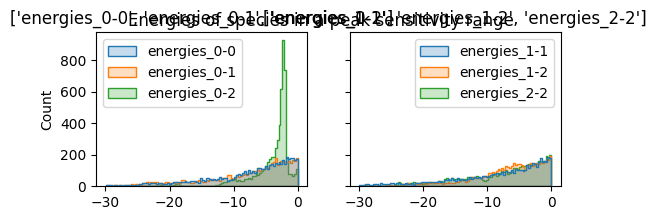

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(2*3, 2), sharex=True, sharey=True)

sns.histplot(df[df[x_cols] != 0][df['Log sensitivity'].between(*df['Log sensitivity'].mode().iloc[0] + np.array([-0.1, 0.1]))][x_cols[:3]], bins=100, element='step',
             ax=axs[0], log_scale=[False, False])
axs[0].set_title(x_cols[:3])
sns.histplot(df[df[x_cols] != 0][df['Log sensitivity'].between(*df['Log sensitivity'].mode().iloc[0] + np.array([-0.1, 0.1]))][x_cols[3:]], bins=100, element='step',
             ax=axs[1], log_scale=[False, False])
axs[1].set_title(x_cols[3:])
plt.suptitle('Energies of species in a peak sensitivity range')

### Reduce the number of null circuits

Text(0.5, 0.98, "Balance of dataset for conditioning variable ['Log sensitivity']")

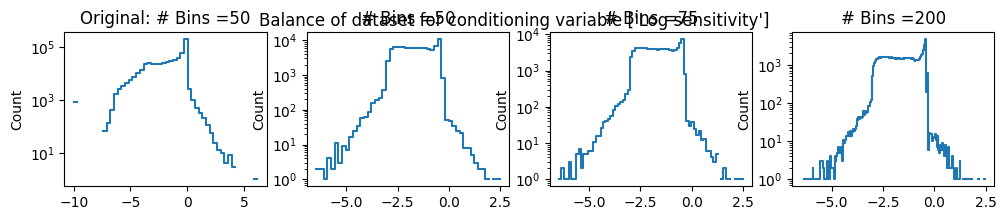

In [12]:
# Balance by bins
nbin = 50
bin_max = int(np.power(10, 4))
# df = balance_dataset(df, cols=config_dataset.objective_col, nbin=nbin, bin_max=bin_max, use_log=False)
# df = balance_dataset(data, cols=X_COLS, nbin=300, bin_max=bin_max, use_log=False, func1=lambda x: np.sum(x, axis=1))

fig = plt.figure(figsize=(4*3, 2))
ax = plt.subplot(1,4,1)
sns.histplot(data[config_dataset.objective_col].to_numpy().flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Original: # Bins =' + str(50))
ax = plt.subplot(1,4,2)
sns.histplot(df[config_dataset.objective_col].to_numpy().flatten(), bins=nbin, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin))
ax = plt.subplot(1,4,3)
sns.histplot(df[config_dataset.objective_col].to_numpy().flatten(), bins=int(nbin*1.5), log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(int(nbin*1.5)))
ax = plt.subplot(1,4,4)
sns.histplot(df[config_dataset.objective_col].to_numpy().flatten(), bins=nbin*4, log_scale=[False, True], element='step', fill=False)
plt.title('# Bins =' + str(nbin*4))

plt.suptitle('Balance of dataset for conditioning variable ' + str(config_dataset.objective_col))


### Scale the input data

Text(0.5, 0.98, 'Dataset after balancing')

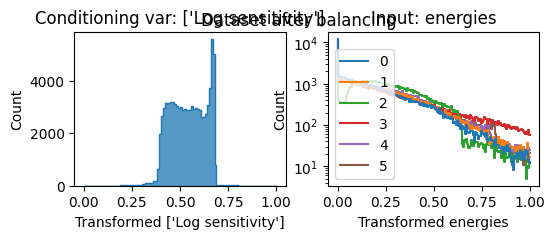

In [13]:
fig = plt.figure(figsize=(2*3, 2))

ax = plt.subplot(1,2,1)
sns.histplot(cond.flatten(), log_scale=[False, False], bins=100, element='step', fill=True)
plt.title(f'Conditioning var: {config_dataset.objective_col}')
plt.xlabel(f'Transformed {config_dataset.objective_col}')

ax = plt.subplot(1,2,2)
sns.histplot(x.reshape(np.prod(x.shape[:-1]), -1), element='step', fill=False, bins=200, log_scale=[False, True])
plt.title(f'Input: {config_dataset.x_type}')
plt.xlabel(f'Transformed {config_dataset.x_type}')

plt.suptitle('Dataset after balancing')

## Init optimiser

In [14]:
optimiser = make_optimiser(config_optimisation.learning_rate_sched, config_training.learning_rate,
                           config_training.epochs, config_training.l2_reg_alpha, config_optimisation.use_warmup,
                           config_optimisation.warmup_epochs, n_batches, config_optimisation.opt_method)
optimiser_state = optimiser.init(params)

# Losses
loss_fn, compute_accuracy = make_loss(
    config_training.loss_func, config_training.use_l2_reg, config_training.use_kl_div, config_training.kl_weight)

dummy_x = jax.random.normal(PRNG, x.shape)
dummy_cond = jax.random.normal(PRNG, cond.shape)

In [15]:
h = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))

In [16]:
model(params, PRNG, x, cond, return_all=False).shape

(363, 256, 6)

In [17]:
# fig = plt.figure(figsize=(3*6, 4))
# i_model = model(params, PRNG, dummy_x, dummy_cond)
# plt.subplot(1,3,1)
# sns.histplot(i_model.flatten(), bins=100, log_scale=[True, False], element='step', fill=False)
# plt.title('Initial output of model (log)')
# plt.subplot(1,3,2)
# sns.histplot(i_model.reshape(np.prod(i_model.shape[:-1]), -1), bins=100, log_scale=[False, False], element='step', fill=False)
# # sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[True, False], element='step', fill=False)
# plt.title('Initial output of model')
# plt.subplot(1,3,3)
# i_enc = encoder(params, PRNG, np.concatenate([dummy_x, dummy_cond], axis=-1))
# sns.histplot(i_enc.reshape(np.prod(i_enc.shape[:-1]), -1), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
# plt.title('Initial embedding of model')
# plt.suptitle(f'Weight init with dummy xy using {config_model.dec_init} and activation {config_model.activation}')


In [18]:
# fig = plt.figure(figsize=(3*6, 4))
# plt.subplot(1,3,1)
# i_model = model(params, PRNG, x, cond)
# sns.histplot(i_model.flatten(), bins=100, log_scale=[True, False], element='step', fill=False)
# plt.title('Initial output of model (log)')
# plt.subplot(1,3,2)
# sns.histplot(i_model.reshape(np.prod(i_model.shape[:-1]), -1), bins=100, log_scale=[False, False], element='step', fill=False)
# # sns.histplot(model(params, PRNG, x, cond), bins=100, log_scale=[True, False], element='step', fill=False)
# plt.title('Initial output of model')
# plt.subplot(1,3,3)
# i_enc = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))
# sns.histplot(i_enc.reshape(np.prod(i_enc.shape[:-1]), -1), bins=100, log_scale=[False, True], element='step', fill=False, legend=False)
# plt.title('Initial embedding of model')
# plt.suptitle(f'Weight init with actual xy using {config_model.dec_init} and activation {config_model.activation}')

In [19]:
# Potential diagnostic code
def print_layer_stats(model):
    for name, module in model.items():
        if 'w' in module:
            print(f"Layer {name}:")
            print(f"  Weight mean: {module['w'].mean().item()}")
            print(f"  Weight std: {module['w'].std().item()}")

# print_layer_stats(params)

# Train

In [20]:
tstart = datetime.now()
params, saves, info_early_stop = train(params, rng, model,
                                       x_train, cond_train, y_train, x_val, cond_val, y_val,
                                       optimiser, optimiser_state, config_training,
                                       epochs=config_training.epochs, loss_fn=loss_fn, compute_accuracy=compute_accuracy,
                                       save_every=config_training.print_every, include_params_in_all_saves=False,
                                       patience=config_training.patience)
print(datetime.now() - tstart)

pred_y = model(params, rng, x_train, cond=cond_train)
r2_train = r2_score(y_train.flatten(), pred_y.flatten())

Train loss: 0.003064334625378251
Val loss: 0.0030023979488760233
Val accuracy: 0.9979844093322754
Epochs no improvement: 0


0:00:41.929408


In [21]:
from evoscaper.scripts.cvae_scan import test


if True:  # config_dataset.use_test_data:
    data_test = pd.read_csv(config_dataset.filenames_verify_table) if config_dataset.filenames_verify_table.endswith('.csv') else pd.read_json(config_dataset.filenames_verify_table)

    r2_test, mi = test(model, params, rng, decoder, saves, data_test,
                        config_dataset, config_norm_y, config_model,
                        x_cols, config_filter, top_write_dir,
                        x_datanormaliser, x_methods_preprocessing,
                        y_datanormaliser, y_methods_preprocessing, visualise=False)
    print(r2_test, mi)

0.9717435836791992 -23.02585


In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
sns.histplot(np.concatenate([df[i].iloc[:total_ds].values[:, None] for i in x_cols], axis=1).squeeze().flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(x).flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of input data')

plt.subplot(1,2,2)
sns.histplot(df[config_dataset.objective_col].iloc[:total_ds].values.flatten(), bins=50, log_scale=[False, True], element='step', fill=False, label='Original')
sns.histplot(np.concatenate([y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(cond, col=c).flatten() for c in config_dataset.objective_col]), bins=50, log_scale=[False, True], element='step', fill=False, label='Preprocessed and then inverted')
plt.legend()
plt.title('Preprocessing of conditional data')

plt.close()

Text(0.5, 1.0, 'Preprocessing of conditional data')

# Visualise

In [24]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

plt.suptitle('Training')

Text(0.5, 0.98, 'Training')

In [25]:
write_json(saves, out_path=save_path)

In [26]:
print(save_path)

data/01_cvae/2025_02_08__16_08_44/saves_2025_02_08__16_08_44_ds1205


# Examine trained model

In [ ]:
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__15_01_35_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_27__16_58_36_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_28__14_12_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_11_29__10_43_59_saves_test')
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_02__13_49_00_saves_test')  # sensitivity
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__14_54_23_saves_test')  # generated from interactions
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_06__17_57_39_saves_test')  # generated from interactions with sigmoid in decoder for 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__17_45_52_saves_no_sigmoid_decoder')  # generated from interactions with sigmoid in decoder for 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__18_59_40_saves_KL_div')  # generated from interactions + relu + sigmoid + KL divergence
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__20_55_42_saves_no_KL')  # generated from interactions + relu + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__21_21_04_saves_no_KL')  # generated from interactions + relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_17_13_saves_leaky_relu')  # generated from interactions + leaky relu 
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__22_48_33_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_08__23_01_53_saves_KL_leakyrelu')  # generated from interactions + leaky relu + KL + encoder head hidden size
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__14_24_25_saves_new_MLP')  # generated from interactions + new MLP
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_28_08_saves_layers_1')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__15_51_40_saves_he_init')  # generated from interactions + only 1 layer for enc and dec
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_13_34_saves_he_init_KL_ls1')  # generated from interactions + only 1 layer for enc and dec + KL
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__16_49_29_saves_robust_KL_e2000')  # generated from interactions + KL + robust scaling + 2000 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__22_09_41_saves_nosigmoid_KL_new_reparam')  # generated from interactions + KL + no sigmoid + new reparameterisation function + sensitivity ---> DID NOT WORK, NANS
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_09__23_27_37_saves_sens_brd_KL_weight')  # generated from interactions + KL + no sigmoid + new reparameterisation function + sensitivity ---> DID NOT WORK, NANS
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__13_36_05_saves_sens_brd_KL_weight')  # generated from interactions + no sigmoid + new reparameterisation function + sensitivity 500 epochs
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__14_31_37_saves_sens_en_lr1e3')  # generated from interactions + log sensitivity 3000 epochs + lr 1e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__14_45_23_saves_sens_en_lr1e3')  # generated from interactions + log sensitivity 3000 epochs + lr 1e-3 + KL + 3 layers instead of 1
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_00_32_saves_onehot')  # generated from interactions + log sensitivity + energies + onehot
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_46_49_saves_onehot_lr1e1')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__17_53_31_saves_onehot_nominmax')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1 + no minmax just robust scaling
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__18_20_05_saves_onehot_minmax_epochs10k')  # generated from interactions + log sensitivity + energies + onehot + lr 1e-1 + 10k epochs + minmax
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_10__21_59_51_saves_onehot_quantile')  # generated from interactions + log sensitivity + onehot + quantile categorical + lr 1e-1 + 10k epochs + minmax
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__11_39_29_saves_log_sens_sigmoid_nocat')  # generated from interactions + log sensitivity + no onehot + lr 5e-2 + 10k epochs + minmax + sigmoid
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__14_22_59_saves_winit_glorot')  # generated from interactions + log sensitivity + no onehot + lr 5e-2 + sigmoid + minmax + glorot init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__15_17_29_saves_henorm_nosig_minmax')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_11__17_54_40_saves_henorm_nosig_minmax')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_12__16_17_49_saves_Eneg_henorm_nosigm_nocat')  # generated from interactions + log sensitivity + no onehot + lr 1e-1 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_13__10_59_59_saves_Eneg_onehot')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_15__18_08_07_saves_Eneg_onehot_ls3')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 64
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_15__18_36_21_saves_Eneg_onehot_ls3_hs32')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__13_19_13_saves_Eneg_onehot_ls2_hs32')  # generated from interactions + log sensitivity + onehot + lr5e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__15_38_11_saves_KLw25e2')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-2
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__16_22_43_saves_KLw25e3')  # generated from interactions + log sensitivity + energies negative onehot + lr5e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__18_48_25_saves_KLw1e3_lr1e1')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 1e-3
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_17__19_05_55_saves_KLw5e4_L21e1')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 5e-4 + L2 reg
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__12_19_07_saves_bug_fix')  # generated from interactions + log sensitivity + energies negative onehot + lr5e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-4
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__17_16_40_saves_L25e2_lr1e1')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-1 + minmax + no sigmoid + he normal init + 2 layers + hidden size 32 + KL weight 2.5e-4
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__21_17_58_saves_lr1e1_nocat_nsamebins50')  # generated from interactions + log sensitivity + energies negative NO onehot + lr1e-1 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32 + KL weight 2.5e-4 + n x same bins 50
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_18__22_06_02_saves_lr1e1_nocat_nsamebins50_ls3_bs256')  # generated from interactions + log sensitivity + energies negative NO onehot + lr1e-1 + minmax + no sigmoid + he normal init + 3 layers + hidden size 32 + KL weight 2.5e-4 + n x same bins 50
fn_saves = os.path.join('weight_saves', '01_cvae', '2024_12_19__16_10_53_saves_hs16_ls32_nlayers2_adam')  # generated from interactions + log sensitivity + energies negative onehot + lr1e-2 + minmax + no sigmoid + he normal init + 2 layers + hidden size 16 + ls 32 + KL weight 2.5e-4 + n x same bins 50
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__15_33_42_adapt')  # objective col adaptation
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_09__21_26_05_prec_sens')  # objective col sens and prec
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_14__17_44_21_sens')  # objective col log sens 
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_17__16_01_57_sens_no_cat')  # objective col log sens without categorical encoding
fn_saves = os.path.join('weight_saves', '01_cvae', 'saves_2025_01_21__22_40_13_no_cat_sens_prec')  # objective col log sens without categorical encoding
fn_saves = os.path.join('data', '01_cvae', '2025_01_23__15_38_01', 'saves_2025_01_23__15_38_01_sens')  # Redo with just sensitivity + no categorical + no KL (KL did not work)
fn_saves = os.path.join('data', '01_cvae', '2025_01_23__15_42_09', 'saves_2025_01_23__15_42_09_sens_cat')  # Same as above but with categorical (onehot) 
fn_saves = os.path.join('data', '01_cvae', '2025_01_23__15_47_33', 'saves_2025_01_23__15_47_33_sens_kl')  # Same as above but no categorical (onehot) and with KL
fn_saves = os.path.join('data', '01_cvae', '2025_01_23__15_52_15', 'saves_2025_01_23__15_52_15_sens_contloss')  # Same as above but no categorical (onehot) with contrastive loss
fn_saves = os.path.join('data', '01_cvae', '2025_01_24__13_53_02', 'saves_2025_01_24__13_53_02_sens_contloss_t2')  # Same as above but no categorical (onehot) with contrastive loss temperature = 2
fn_saves = os.path.join('data', '01_cvae', '2025_01_24__15_40_26', 'saves_2025_01_24__15_40_26_sens_contloss_t1_5')  # Same as above but no categorical (onehot) with contrastive loss temperature = 1.5
fn_saves = os.path.join('data', '01_cvae', '2025_01_25__12_23_51', 'saves_2025_01_25__12_23_51_sens_kl_25e3')  # Same as above but no categorical (onehot) and with KL weight = 2.5e-3
fn_saves = os.path.join('data', '01_cvae', '2025_01_26__14_20_07', 'saves_2025_01_26__14_20_07_sens_kl_1e3')  # Same as above but no categorical (onehot) and with KL weight = 1e-3
fn_saves = os.path.join('data', '01_cvae', '2025_01_26__16_16_36', 'saves_2025_01_26__16_16_36_sens_kl_8e4')  # Same as above but no categorical (onehot) and with KL weight = 8e-4
fn_saves = os.path.join('data', '01_cvae', '2025_01_26__16_32_02', 'saves_2025_01_26__16_32_02_sens_kl_5e4')  # Same as above but no categorical (onehot) and with KL weight = 5e-4
fn_saves = os.path.join('data', '01_cvae', '2025_01_31__21_46_50', 'saves_2025_01_31__21_46_50_ds2')  # New dataset 2 ('./data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json) + no response time filer
fn_saves = os.path.join('data', '01_cvae', '2025_01_31__21_52_42', 'saves_2025_01_31__21_52_42_ds2_resp')  # New dataset 2 ('./data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json) + with response time filter
fn_saves = os.path.join('data', '01_cvae', '2025_01_31__23_07_54', 'saves_2025_01_31__23_07_54_ds1_fresp')  # New dataset 1 ('./data/simulate_circuits/2025_01_29__14_52_44/tabulated_mutation_info.json) + with response time filter
fn_saves = os.path.join('data', '01_cvae', '2025_01_31__23_11_09', 'saves_2025_01_31__23_11_09_ds1_thresh95')  # New dataset 1 ('./data/simulate_circuits/2025_01_29__14_52_44/tabulated_mutation_info.json) + with response time filter + threshold 0.95
fn_saves = os.path.join('data', '01_cvae', '2025_02_02__16_05_03', 'saves_2025_02_02__16_05_03_ds3')  # New dataset 3 ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json)
fn_saves = os.path.join('data', '01_cvae', '2025_02_02__16_18_20', 'saves_2025_02_02__16_18_20_ds3')  # New dataset 3 ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json) --> redid balancing func
fn_saves = os.path.join('data', '01_cvae', '2025_02_02__18_26_09', 'saves_2025_02_02__18_26_09_ds3')  # New dataset 3 ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json) forgot to set balancing hpo
fn_saves = os.path.join('data', '01_cvae', '2025_02_02__19_14_12', 'saves_2025_02_02__19_14_12_ds0_ds3test')  # Train with old dataset ds0 (data/raw/summarise_simulation/2024_12_05_210221) and verify with new dataset 3 ('./data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json) 
fn_saves = os.path.join('data', '01_cvae', '2025_02_07__17_29_29', 'saves_2025_02_07__17_29_29_dssim1')  # Train with most recent dataset of parameter-based simulation (not sequence-based)
fn_saves = os.path.join('data', '01_cvae', '2025_02_07__22_15_21', 'saves_2025_02_07__22_15_21_dssim0128')  # Train less recent dataset of parameter-based simulation 
fn_saves = os.path.join('data', '01_cvae', '2025_02_08__16_08_44', 'saves_2025_02_08__16_08_44_ds1205')  # Re-do `saves_2025_01_14__17_44_21_sens`
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(363, 256, 6)

Text(0.5, 0.98, 'Training')

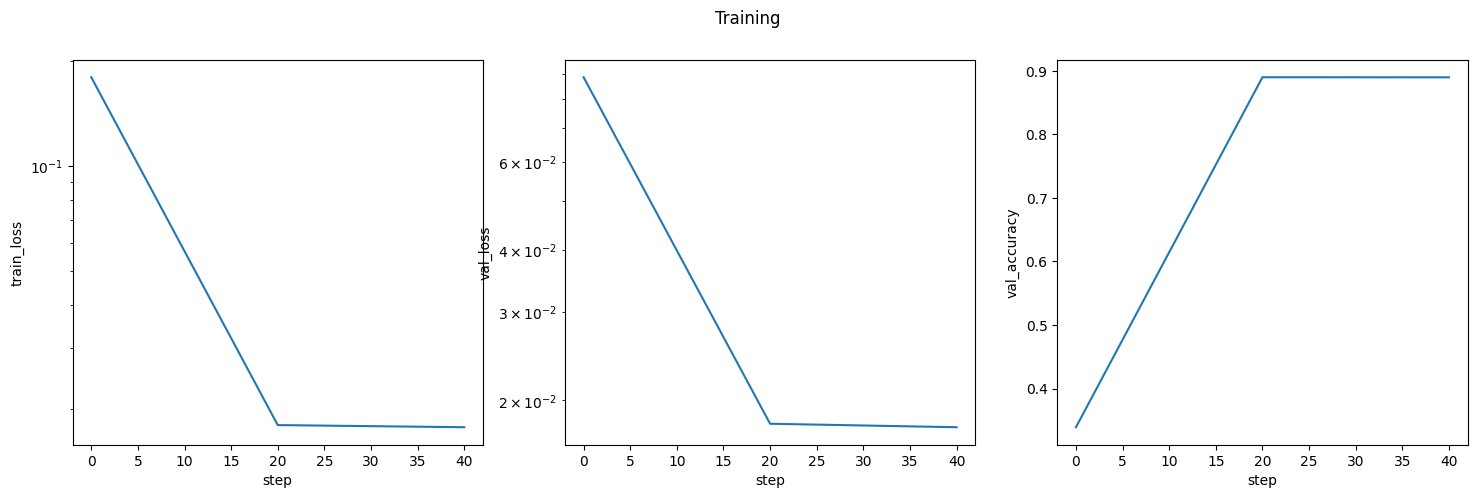

In [21]:
plt.figure(figsize=(6*3, 5))
ax = plt.subplot(1, 3, 1)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['train_loss']) for v in saves_loaded.values()]))
plt.yscale('log')
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_loss']) for v in saves_loaded.values()]))
plt.yscale('log')
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_accuracy']) for v in saves_loaded.values()]))
plt.ylabel('val_accuracy')
plt.xlabel('step')
plt.suptitle('Training')

/tmp/ipykernel_3513201/3813921430.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.histplot(x=pred_y.flatten(), y=y.flatten(), palette='viridis')


[Training] The R2 score is  0.9787958264350891
[Training] The R2 score with weighted variance is  0.9787958264350891
[Validation] The R2 score is  0.9787396788597107
[Validation] The R2 score with weighted variance is  0.9787396192550659


/tmp/ipykernel_3513201/3813921430.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.histplot(x=pred_y_val.flatten(), y=y_val.flatten(), palette='viridis')


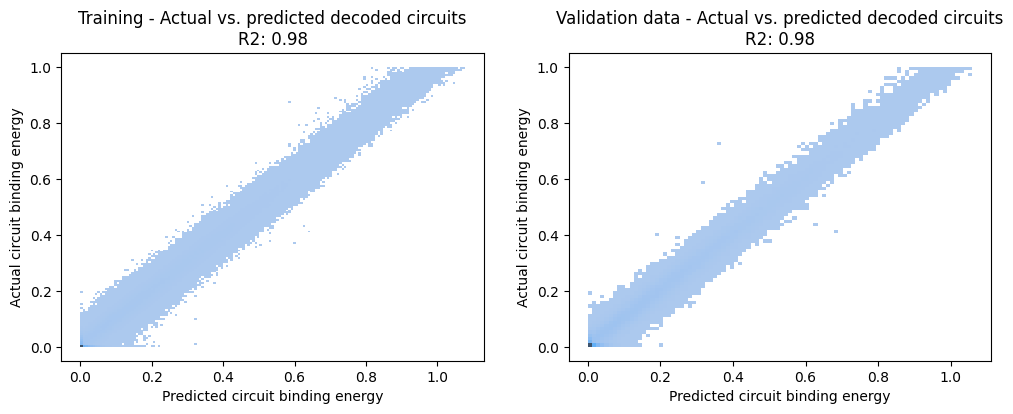

In [22]:
fig = plt.figure(figsize=(2*6, 4))

ax = plt.subplot(1,2,1)
g = sns.histplot(x=pred_y.flatten(), y=y.flatten(), palette='viridis')
# g = sns.scatterplot(x=pred_y.flatten(), y=y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
# g.legend_.set_title('Sqare root of difference')
plt.title(f'Training - Actual vs. predicted decoded circuits\nR2: {r2_score(y.flatten(), pred_y.flatten()):.2f}')
plt.xlabel('Predicted circuit binding energy')
plt.ylabel('Actual circuit binding energy')

print('[Training] The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('[Training] The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

pred_y_val = model(p, PRNG, x_val, cond_val)

ax = plt.subplot(1,2,2)
g = sns.histplot(x=pred_y_val.flatten(), y=y_val.flatten(), palette='viridis')
# g = sns.scatterplot(x=pred_y_val.flatten(), y=y_val.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y_val.flatten() - y_val.flatten())), palette='viridis')
# g.legend_.set_title('Sqare root of difference')
plt.title(f'Validation data - Actual vs. predicted decoded circuits\nR2: {r2_score(y_val.flatten(), pred_y_val.flatten()):.2f}')
plt.xlabel('Predicted circuit binding energy')
plt.ylabel('Actual circuit binding energy')

print('[Validation] The R2 score is ', r2_score(y_val.flatten(), pred_y_val.flatten()))
print('[Validation] The R2 score with weighted variance is ', r2_score(
    y_val.flatten(), pred_y_val.flatten(), multioutput='variance_weighted'))


# Sample fake circuits

In [23]:
n_to_sample = 10000

sampled_cond = np.interp(jax.random.normal(PRNG, (n_to_sample, cond.shape[-1])), [0, 1], [cond.min(), cond.max()])
sampled_h = np.random.rand(n_to_sample, config_model.enc_ls)
# mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 10
# logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 0.5
# mu = h2mu(p, PRNG, sampled_h) 
# logvar = h2logvar(p, PRNG, sampled_h)
# z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = jax.random.normal(PRNG, (n_to_sample, config_model.hidden_size))
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10000, 1)

Text(0.5, 1.0, 'Generated fake circuits')

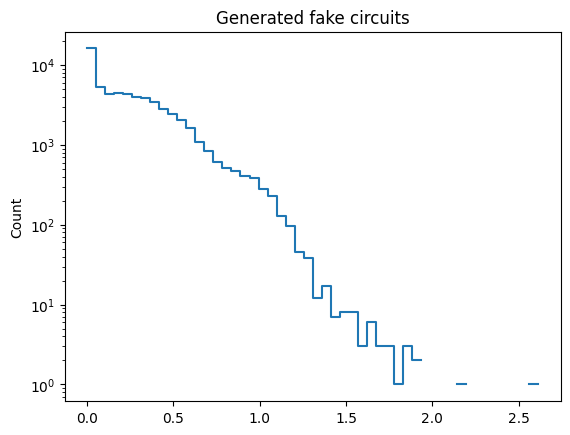

In [24]:
sns.histplot(fake_circuits.flatten(), bins=50, log_scale=[False, True], element='step', fill=False)
plt.title('Generated fake circuits')

Text(0.5, 0.98, 'Interactions for CVAE: 10000 circuits')

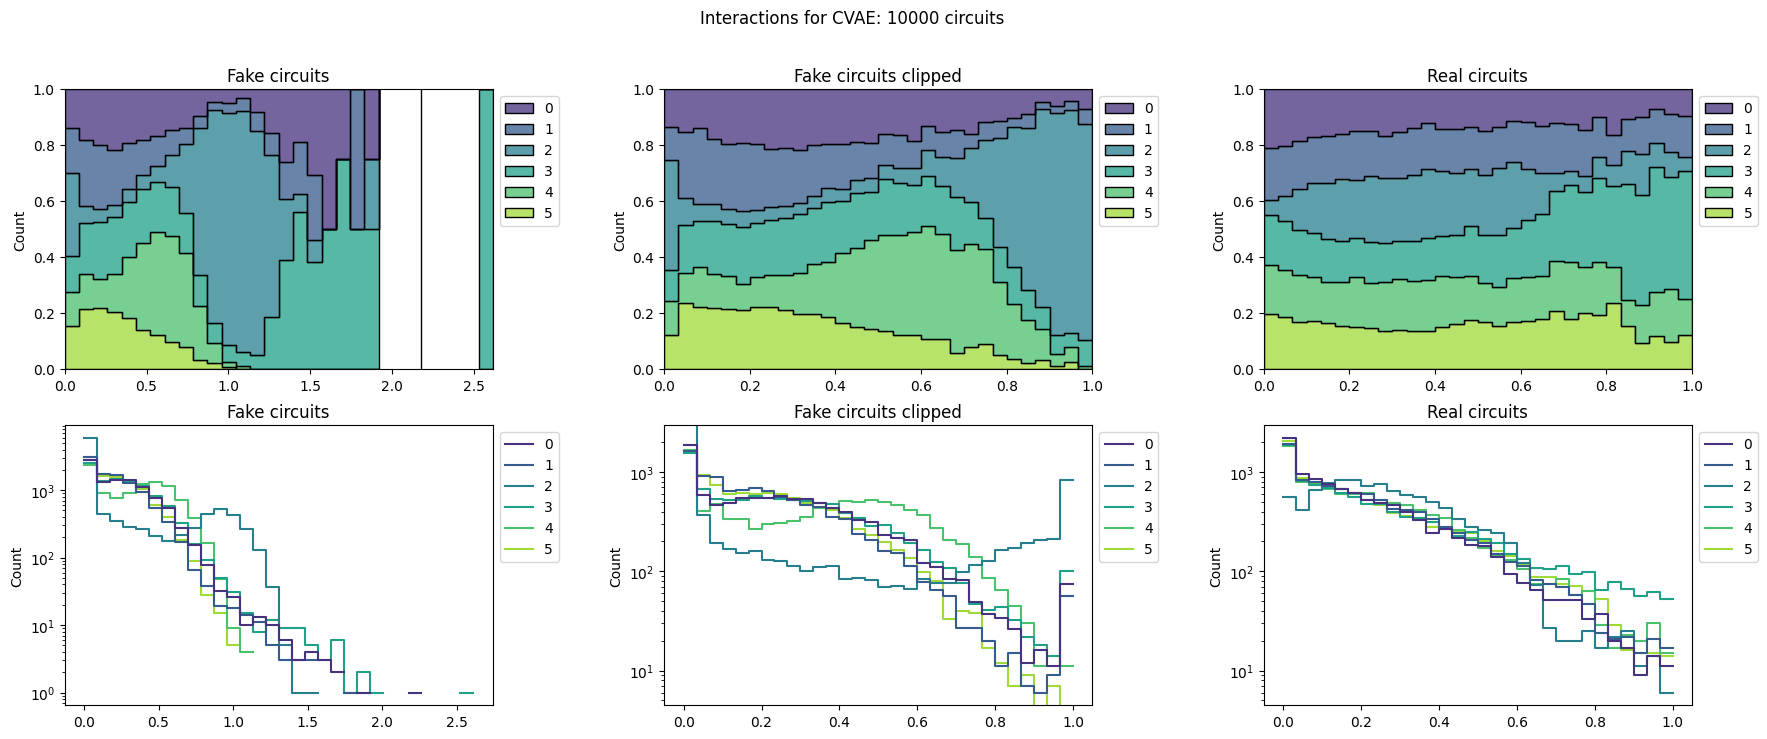

In [25]:
fig = plt.figure(figsize=(7*3, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2, 3, 1)
g = sns.histplot(fake_circuits, element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 2)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30,
                 palette='viridis', multiple='fill')
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 3)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample],
                 element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Real circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 4)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 5)
g = sns.histplot(np.where(fake_circuits > x.max(), x.max(), np.where(fake_circuits < x.min(), x.min(), fake_circuits)), 
                 element='step', bins=30, palette='viridis',
                 multiple='layer', fill=False, log_scale=[False, True])
plt.title('Fake circuits clipped')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2, 3, 6)
x_hist = x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample]
g2 = sns.histplot(x_hist, element='step', bins=30, palette='viridis',
                  multiple='layer', fill=False, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'Interactions for CVAE: {n_to_sample} circuits')

Text(0.5, 0.98, 'CVAE: 2000 circuits')

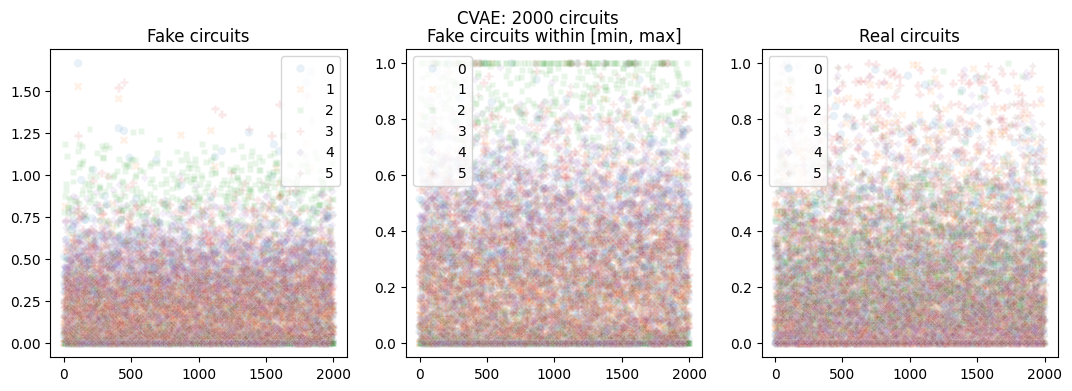

In [26]:
fig = plt.figure(figsize=(13, 4))

show_max = 2000

ax = plt.subplot(1, 3, 1)
sns.scatterplot(fake_circuits[:show_max], alpha=0.1)
plt.title('Fake circuits')

ax = plt.subplot(1, 3, 2)
fake_circuits_1 = np.where(fake_circuits[:show_max] > x.max(), x.max(), fake_circuits[:show_max])
sns.scatterplot(np.where(fake_circuits_1 < x.min(), x.min(), fake_circuits_1), alpha=0.1)
plt.title('Fake circuits within [min, max]')

ax = plt.subplot(1, 3, 3)
sns.scatterplot(
    x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max], alpha=0.1)
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')

## Conditionality

In [27]:
n_obj = len(config_dataset.objective_col)
n_categories = 5 if not config_norm_y.categorical_onehot else config_norm_y.categorical_n_bins
n_to_sample = 2000
print('Total to sample: ', n_categories ** n_obj * n_to_sample)

Total to sample:  10000


In [28]:
if config_norm_y.categorical_onehot:
    sampled_cond = np.repeat(np.arange(config_norm_y.categorical_n_bins)[:, None], repeats=n_to_sample, axis=1)
    sampled_cond = jax.nn.one_hot(sampled_cond, config_norm_y.categorical_n_bins)
    for k in config_dataset.objective_col[1:]:
        sampled_cond2 = np.repeat(np.arange(config_norm_y.categorical_n_bins)[:, None], repeats=n_to_sample, axis=1)
        sampled_cond2 = jax.nn.one_hot(sampled_cond2, config_norm_y.categorical_n_bins)
        sampled_cond = np.concatenate([sampled_cond, sampled_cond2], axis=-1)
else:
    sampled_cond_nonrepeated = np.array(list(itertools.product(*([np.linspace(cond.min(), cond.max(), n_categories).tolist()] * n_obj))))
    sampled_cond = np.repeat(sampled_cond_nonrepeated, repeats=n_to_sample, axis=1).reshape(n_categories ** n_obj, n_to_sample, n_obj)
    # sampled_cond = np.repeat(s[:, :, None], repeats=n_to_sample, axis=2)
    # s = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
z = jax.random.normal(PRNG, (n_categories ** n_obj, n_to_sample, config_model.hidden_size))
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(inputs=z)

fake_circuits.shape, sampled_cond.shape

((5, 2000, 6), (5, 2000, 1))

In [37]:
# # sns.histplot(decoder(p, PRNG, z).flatten(), bins=50)
# sns.histplot(fake_circuits.flatten(), bins=50, element='step')
# plt.title('Fake circuits params')

In [35]:
# n_show_max = 10
# ncols = 2
# nrows = n_show_max // ncols + 1
# for k in config_dataset.objective_col:

#     fig = plt.figure(figsize=(10*ncols, 5*nrows))
#     show_max = 300 #n_to_sample
#     widest_lim = [0, 0]
#     for i, (zi, cat) in enumerate(zip(z[:n_show_max], fake_circuits[:n_show_max])):
#         ax = plt.subplot(nrows, ncols, i+1)
#         # g = sns.scatterplot(cat[:show_max])
#         g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
#         if config_norm_y.categorical_onehot:
#             plt.title(f'Fake circuit: {k} = {y_datanormaliser.metadata[k]["category_map"][i]:.2f}')
#         else:
#             plt.title(f'Fake circuit: {k} = {str(sampled_cond_nonrepeated[i])}')
#         sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
#         widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
#         widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
#         g.set_xlim(widest_lim)

#     break
# plt.suptitle(f'CVAE: fake circuits ({config_dataset.objective_col})')

## Compare to real circuit's objective

In [31]:
def apply_fns(x, fns: list):
    og_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(*(np.prod(x.shape[:-1]), x.shape[-1]))
    for fcn in fns:
        x = fcn(x)
    return x.reshape(og_shape)

for k in config_dataset.objective_col:
    df = df[~df[k].isna()]
    df[k + '_nearest_edge'] = bin_to_nearest_edge(df[k].to_numpy(), n_bins=n_categories)
fake_circuits = x_datanormaliser.create_chain_preprocessor_inverse(x_methods_preprocessing)(fake_circuits)


In [36]:
# for k in config_dataset.objective_col:
#     fig = plt.figure(figsize=(10*2, 5*5))
#     show_max = 300 #n_to_sample
#     widest_lim = [0, 0]
#     for i, edge in enumerate(sorted(df[k + '_nearest_edge'].unique())):
#         cat = df[df[k + '_nearest_edge'] == edge]
#         cat = cat[x_cols].to_numpy()
        
#         ax = plt.subplot(5, 2, i+1)
#         # g = sns.scatterplot(cat[:show_max])
#         g = sns.histplot(cat, element='step', bins=30, palette='magma', multiple='fill')
#         plt.title(f'Real circuit: {k} = {str(edge)[:6]}')
#         sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
#         widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
#         widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
#         g.set_xlim(widest_lim)
        
#     break

# plt.suptitle(f'CVAE: real circuits {config_dataset.objective_col}')

## Combined

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real Log sensitivity')

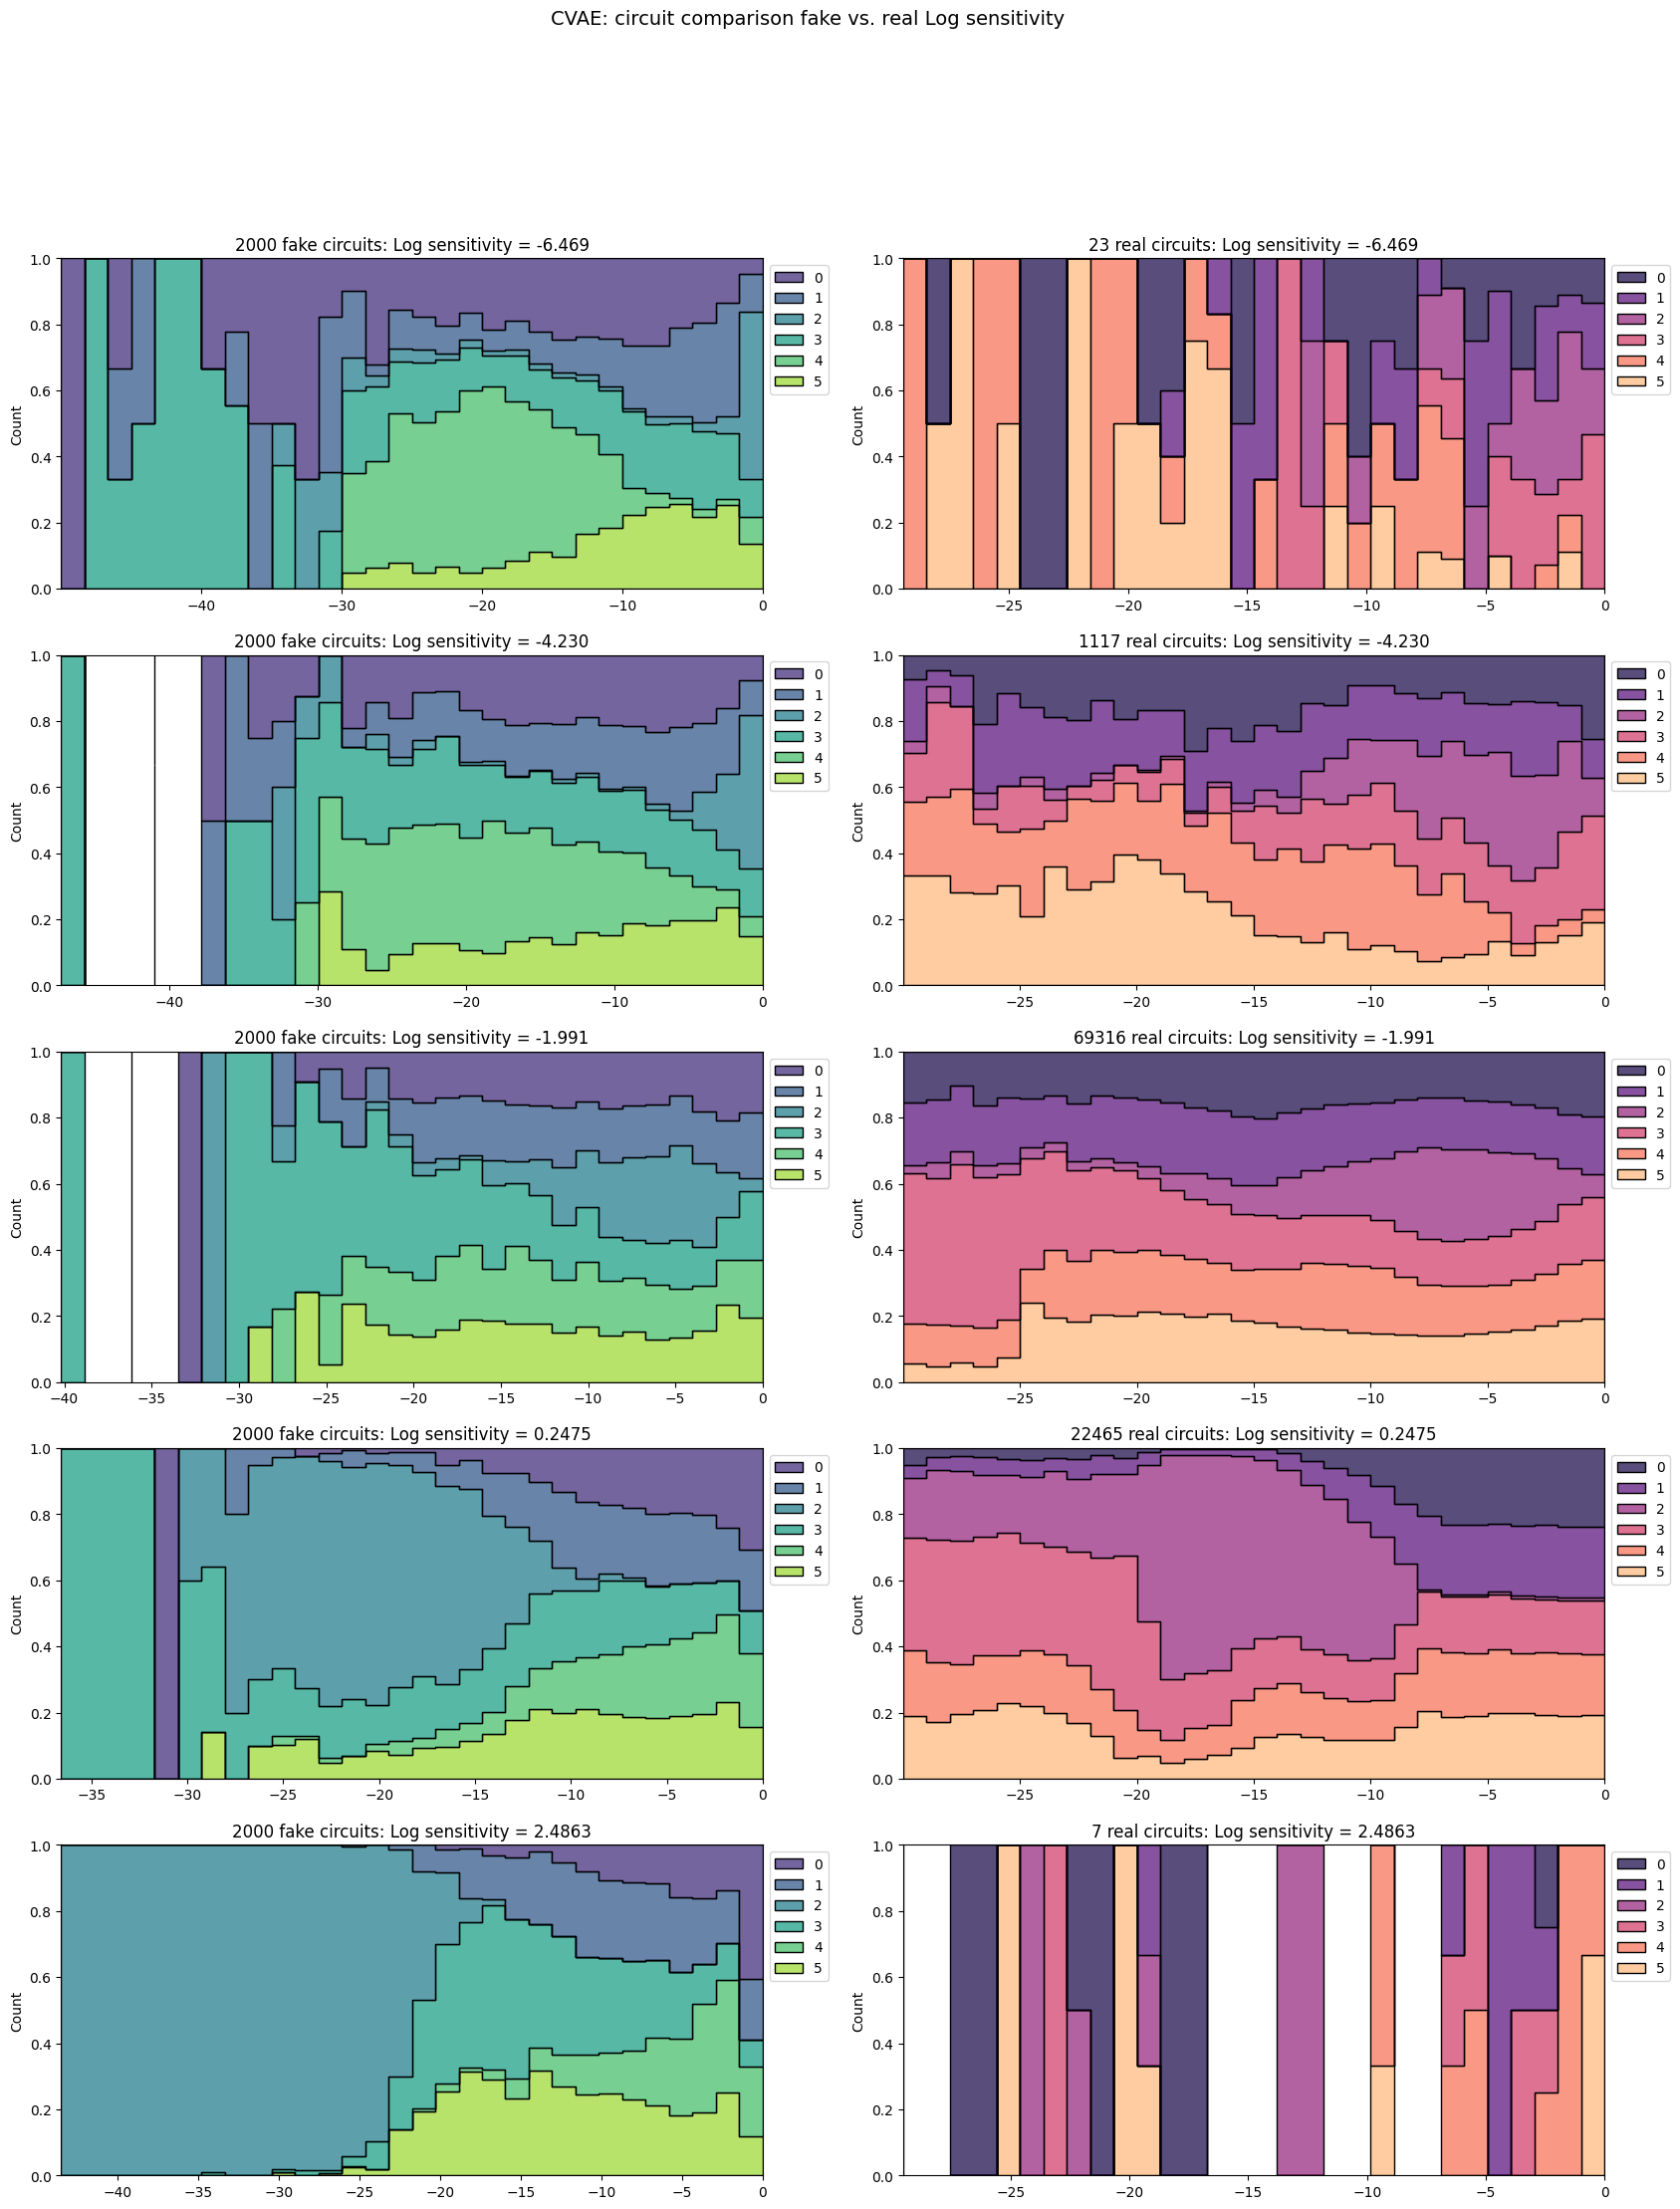

In [33]:
for k in config_dataset.objective_col:
    fig = plt.figure(figsize=(10*2, n_categories*5))
    show_max = 300 #n_to_sample
    for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[k + '_nearest_edge'].unique()))):
        widest_lim = [0, 0]
        real = df[df[k + '_nearest_edge'] == edge][x_cols].to_numpy()
        
        ax = plt.subplot(n_categories, 2, 2*i+1)
        # g = sns.scatterplot(cat[:show_max])
        g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill')
        sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
        sc = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc, col=k)
        # plt.title(f'{len(fake)} fake circuits: {k} = {str(sc.flatten()[i])[:6]}')
        if config_norm_y.categorical_onehot:
            plt.title(f'{len(fake)} fake circuits: {k} = {y_datanormaliser.metadata[k]["category_map"][i]:.2f}')
        else:
            plt.title(f'{len(fake)} fake circuits: {k} = {str(sc.flatten()[i])[:6]}')
        sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
        
        ax = plt.subplot(n_categories, 2, 2*i+2)
        # g = sns.scatterplot(cat[:show_max])
        g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='fill')
        plt.title(f'{len(real)} real circuits: {k} = {str(edge)[:6]}')
        sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
        
        widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
        # g1.set_xlim(widest_lim)
        # g2.set_xlim(widest_lim)

    break

plt.suptitle(f'CVAE: circuit comparison fake vs. real {k}', fontsize=14)

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real Log sensitivity')

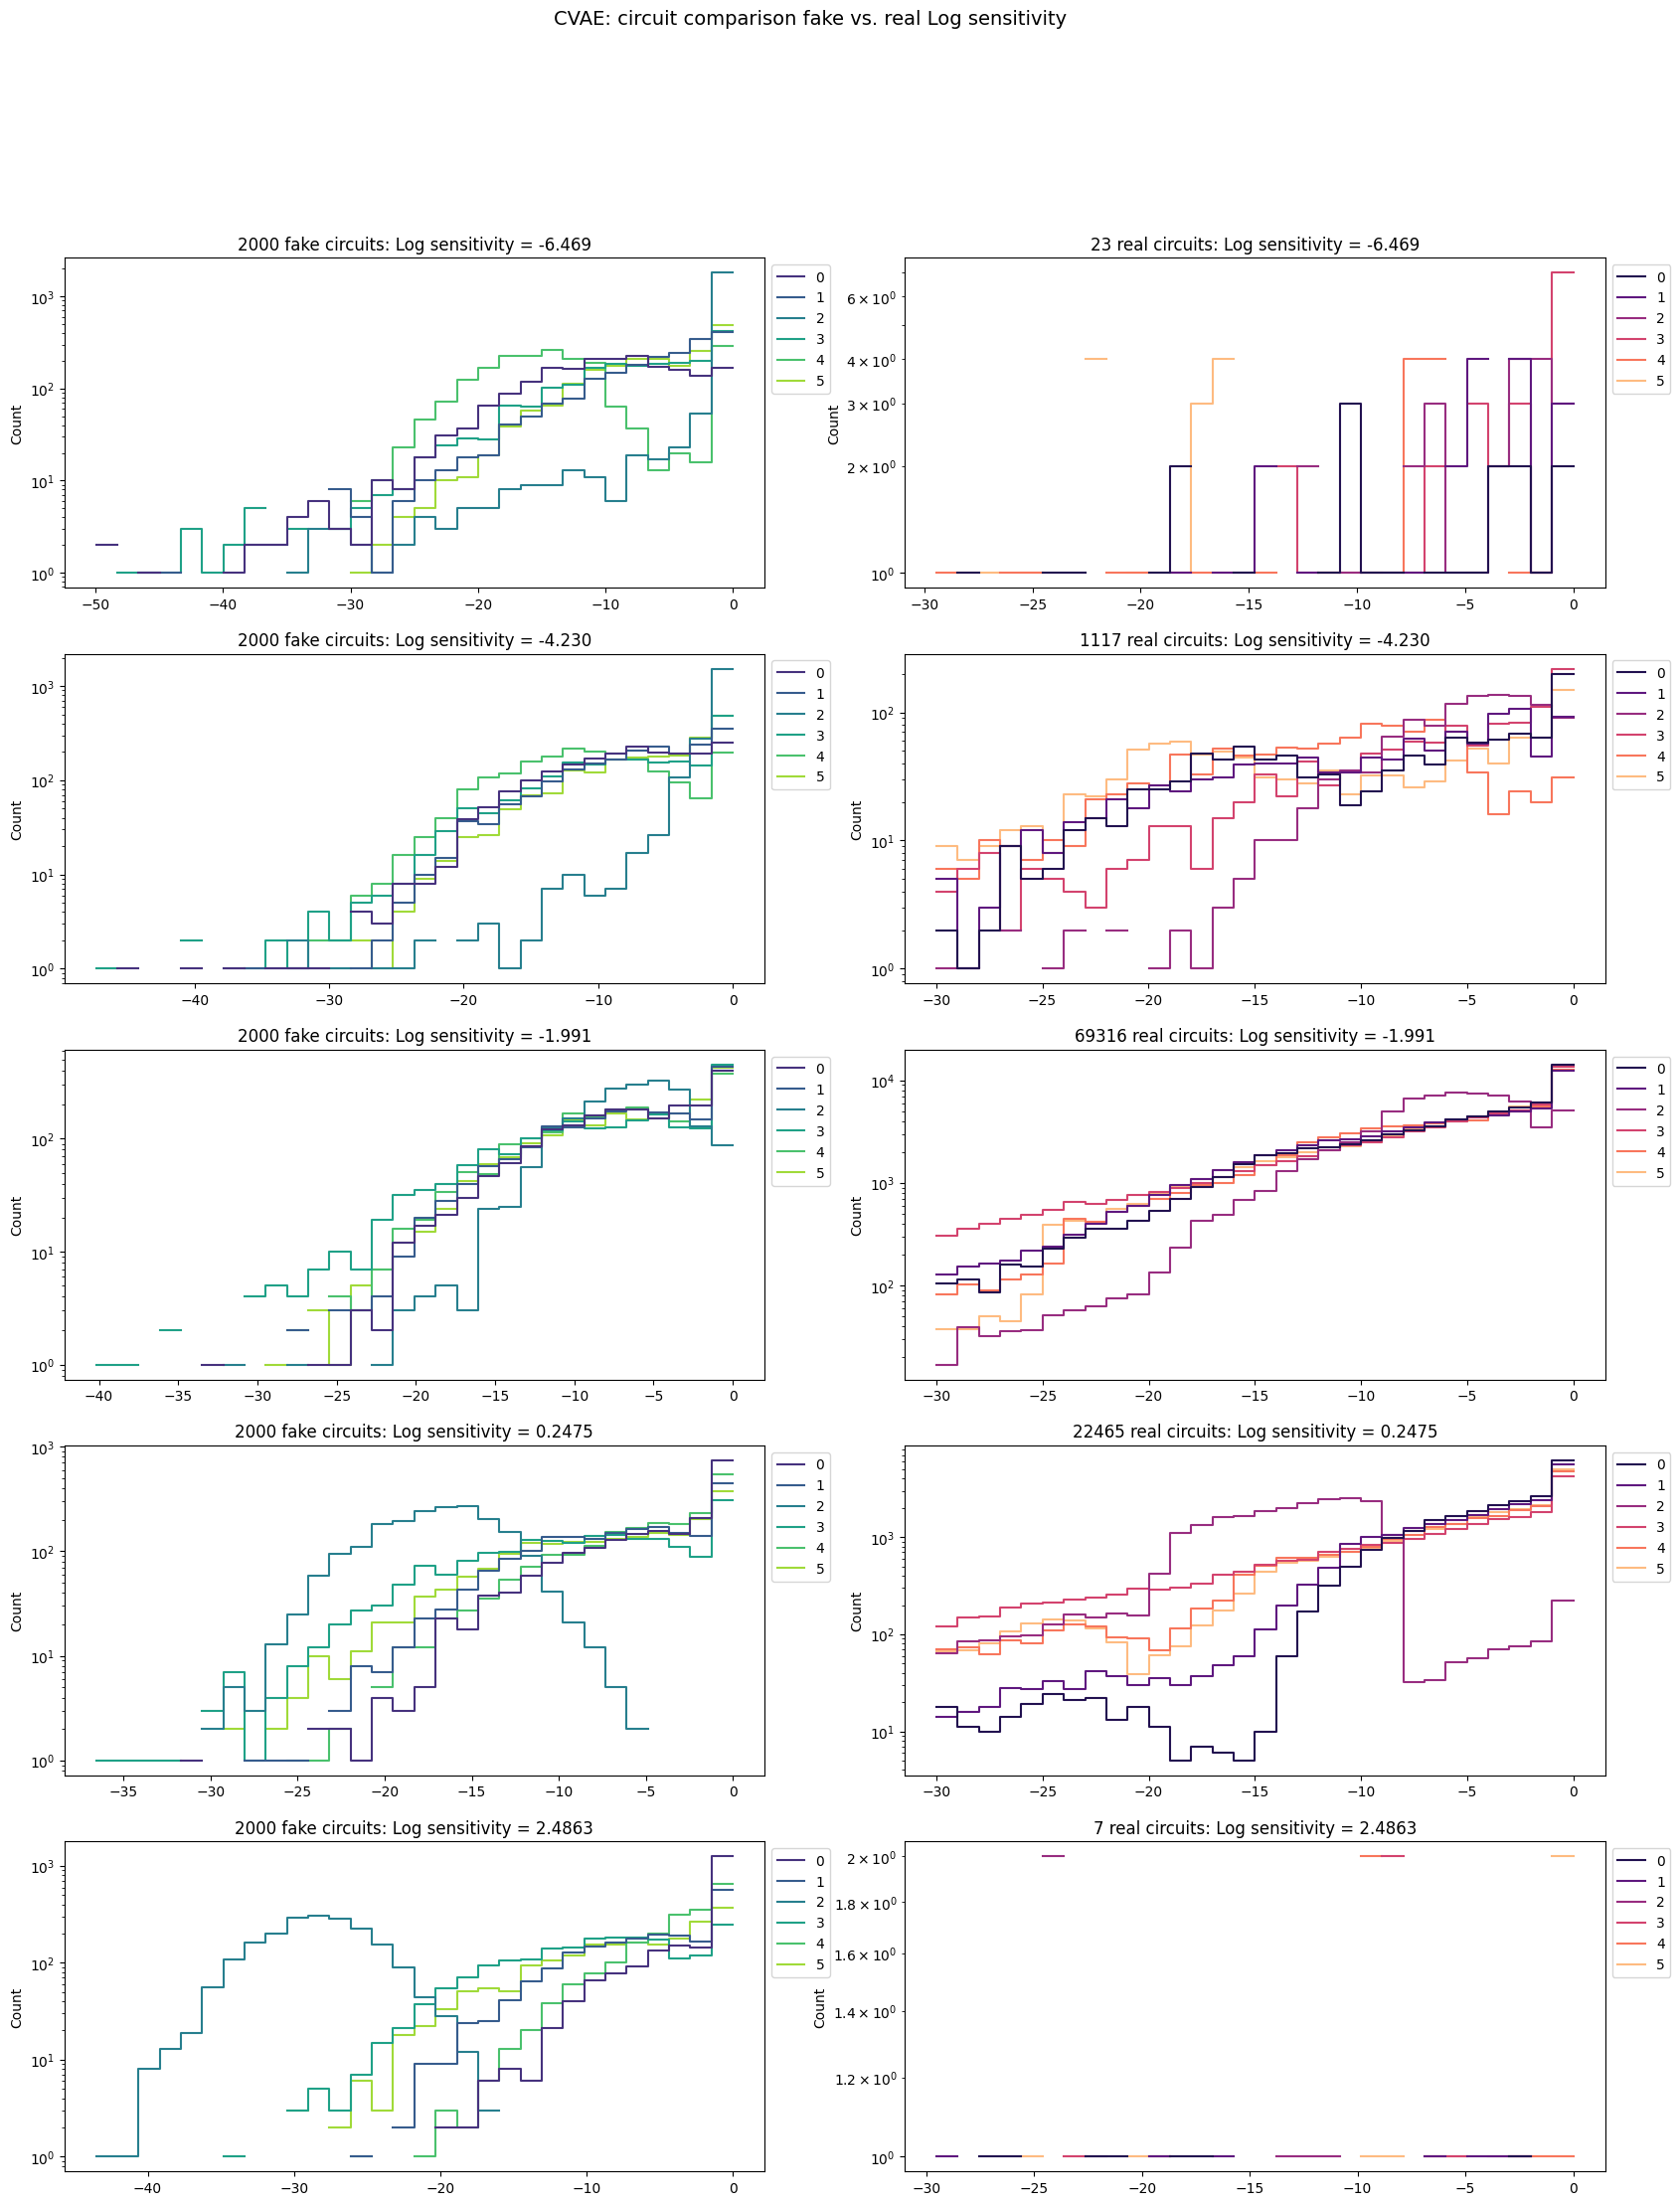

In [34]:
k = config_dataset.objective_col[0]

fig = plt.figure(figsize=(10*2, n_categories*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[k + '_nearest_edge'].unique()))):
    real = df[df[k + '_nearest_edge'] == edge][x_cols].to_numpy()
    
    ax = plt.subplot(n_categories, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', fill=False, log_scale=[False, True])
    sc = np.array(sorted(np.unique(sampled_cond)))[:, None]
    sc = y_datanormaliser.create_chain_preprocessor_inverse(y_methods_preprocessing)(sc, col=k)
    if config_norm_y.categorical_onehot:
        plt.title(f'{len(fake)} fake circuits: {k} = {y_datanormaliser.metadata[k]["category_map"][i]:.2f}')
    else:
        plt.title(f'{len(fake)} fake circuits: {k} = {str(sc.flatten()[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(n_categories, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='magma', multiple='layer', fill=False, log_scale=[False, True])
    plt.title(f'{len(real)} real circuits: {k} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_xlim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1]])]
    widest_ylim = [np.min([g1.get_ylim()[0], g2.get_ylim()[0]]), np.max([g1.get_ylim()[1], g2.get_ylim()[1]])]
    # g1.set_xlim(widest_xlim)
    # g2.set_ylim(widest_ylim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real {k}', fontsize=14)